# Max Tokens Performance Comparison

This notebook compares model performance across different max_tokens settings (4096, 8192, 16384) on subsampled datasets.

Three relational complexity levels:
- **C1 (Q2)**: Constitutional Isomer Set Classification - Metric: Accuracy
- **C2 (Q1a)**: Largest Common Motif - Metric: Is Substructure
- **C3 (Q3)**: Missing Constitutional Isomers - Metric: Recall

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdFMCS

# Set style for plots - clean, no grid
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 12

# Colors matching plot_relational_complexity.ipynb
custom_colors = ['#FFC1AD', '#FF6B35', '#CC4B24']  # Light orange, Orange, Dark orange

## Helper Functions

In [2]:
def load_results(file_path, model_name, max_tokens):
    """Load results from a JSONL file and add model name and max_tokens"""
    results = []
    
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        return results
    
    # Check if file is empty
    if Path(file_path).stat().st_size == 0:
        print(f"Warning: {file_path} is empty, skipping...")
        return results
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            result['max_tokens'] = max_tokens
            results.append(result)
    
    return results

def get_num_atoms(smiles):
    """Get number of heavy atoms in molecule"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol.GetNumHeavyAtoms()

def is_substructure(query_smiles, target_smiles):
    """Check if query is a substructure of target"""
    query_mol = Chem.MolFromSmiles(query_smiles)
    target_mol = Chem.MolFromSmiles(target_smiles)
    
    if query_mol is None or target_mol is None:
        return False
    
    return target_mol.HasSubstructMatch(query_mol)

def calculate_overlap_metric(response_smiles, correct_smiles):
    """Calculate atom overlap metric: N_overlap / max(N_response, N_correct)"""
    response_mol = Chem.MolFromSmiles(response_smiles)
    correct_mol = Chem.MolFromSmiles(correct_smiles)
    
    if response_mol is None or correct_mol is None:
        return 0.0
    
    n_response = response_mol.GetNumHeavyAtoms()
    n_correct = correct_mol.GetNumHeavyAtoms()
    
    if correct_mol.HasSubstructMatch(response_mol):
        n_overlap = n_response
    elif response_mol.HasSubstructMatch(correct_mol):
        n_overlap = n_correct
    else:
        mcs = rdFMCS.FindMCS([response_mol, correct_mol], timeout=5)
        if mcs.smartsString:
            mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            if mcs_mol:
                n_overlap = mcs_mol.GetNumHeavyAtoms()
            else:
                n_overlap = 0
        else:
            n_overlap = 0
    
    max_atoms = max(n_response, n_correct)
    if max_atoms == 0:
        return 0.0
    
    return n_overlap / max_atoms

## C1 (Q2): Constitutional Isomer Set Classification

Metric: **Accuracy**

In [3]:
# Load C1 (Q2) results for different max_tokens settings
c1_results = []

# Define models and max_tokens values
models = [
    ('claude-opus-4-5', 'claude-opus-4-5-20251101'),
    ('gpt-5.2', 'gpt-5.2'),
    ('gemini-3-pro-preview', 'gemini-3-pro-preview'),
]

max_tokens_values = [4096, 8192, 16384]

for model_name, model_id in models:
    for max_tokens in max_tokens_values:
        file_path = f'runs/{model_id}_subsample_tokens{max_tokens}/q2_subsample.jsonl'
        results = load_results(file_path, model_name, max_tokens)
        for res in results:
            c1_results.append([model_name, res['n_molecules'], res['score']['correct'], max_tokens])

c1_df = pd.DataFrame(c1_results, columns=['Model', 'n_molecules', 'correct', 'max_tokens'])
c1_df['n_mol_bin'] = pd.cut(c1_df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])
c1_df_agg = c1_df.groupby(['Model', 'n_mol_bin', 'max_tokens'], observed=True).agg({'correct': 'mean'}).reset_index()
c1_df_agg['Task'] = 'C1'
c1_df_agg.rename(columns={'correct': 'Task Completion'}, inplace=True)

print(f"Loaded {len(c1_df)} C1 (Q2) results total")
print(f"\nC1 Summary by max_tokens:")
print(c1_df_agg.groupby('max_tokens')['Task Completion'].mean())

Loaded 900 C1 (Q2) results total

C1 Summary by max_tokens:
max_tokens
4096     0.686111
8192     0.688889
16384    0.686111
Name: Task Completion, dtype: float64


## C2 (Q1a): Largest Common Motif

Metric: **Is Substructure** (average of response_is_substructure_of_correct and correct_is_substructure_of_response)

In [4]:
# Load the dataset to get ground truth
dataset = []
with open('data/subsample/dataset_q1a_10_per_n.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))

q1a_dataset = [d for d in dataset if d['task'] == 'q1a_largest_common_motif_chembl']
dataset_lookup = {d['id']: d for d in q1a_dataset}

print(f"Total Q1a instances in dataset: {len(q1a_dataset)}")

# Load C2 (Q1a) results for different max_tokens settings
all_results = []

for model_name, model_id in models:
    for max_tokens in max_tokens_values:
        file_path = f'runs/{model_id}_subsample_tokens{max_tokens}/q1a_subsample.jsonl'
        results = load_results(file_path, model_name, max_tokens)
        for result in results:
            result['max_tokens_label'] = f'{max_tokens}'
            all_results.append(result)

# Enrich results with substructure metrics
enriched_results = []

for result in all_results:
    instance_id = result['id']
    
    if instance_id not in dataset_lookup:
        continue
    
    correct_smiles = result['score'].get('gold_canonical') or result['score'].get('gold')
    response_smiles = result['score'].get('pred_canonical') or result['score'].get('pred')
    
    if response_smiles is None:
        response_is_sub = False
        correct_is_sub = False
    else:
        response_is_sub = is_substructure(response_smiles, correct_smiles) if correct_smiles else False
        correct_is_sub = is_substructure(correct_smiles, response_smiles) if correct_smiles else False
    
    enriched_results.append({
        'model': result['model_name'],
        'n_molecules': result['n_molecules'],
        'response_is_substructure_of_correct': response_is_sub,
        'correct_is_substructure_of_response': correct_is_sub,
        'max_tokens': result['max_tokens']
    })

# Convert to DataFrame and calculate is_substructure metric
c2_df = pd.DataFrame(enriched_results)
c2_df['n_mol_bin'] = pd.cut(c2_df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])

c2_df_agg = c2_df.groupby(['model', 'n_mol_bin', 'max_tokens'], observed=True).agg({
    'response_is_substructure_of_correct': 'mean',
    'correct_is_substructure_of_response': 'mean'
}).reset_index()

c2_df_agg['is_substructure'] = 0.5 * (
    c2_df_agg['correct_is_substructure_of_response'] + 
    c2_df_agg['response_is_substructure_of_correct']
)

c2_df_final = c2_df_agg[['model', 'n_mol_bin', 'max_tokens', 'is_substructure']].copy()
c2_df_final['Task'] = 'C2'
c2_df_final.rename(columns={'is_substructure': 'Task Completion', 'model': 'Model'}, inplace=True)

print(f"\nLoaded {len(c2_df)} C2 (Q1a) results total")
print(f"\nC2 Summary by max_tokens:")
print(c2_df_final.groupby('max_tokens')['Task Completion'].mean())

Total Q1a instances in dataset: 100

Loaded 900 C2 (Q1a) results total

C2 Summary by max_tokens:
max_tokens
4096     0.364815
8192     0.365741
16384    0.363889
Name: Task Completion, dtype: float64


[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CC12CCC3C(C)CCC2C1'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CC12CCC3C(C)CCC2C1'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(OC2OC(C)CC(N(C)C)C2O)'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(OC2OC(C)CC(N(C)C)C2O)'
[13:48:21] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6
[13:48:21] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)CC(C)C(=O)C'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)CC(C)C(=O)C'
[13:48:21] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)C'
[13:48:21] SM

## C3 (Q3): Missing Constitutional Isomers

Metric: **Recall**

In [5]:
# Load C3 (Q3) results for different max_tokens settings
c3_results = []

for model_name, model_id in models:
    for max_tokens in max_tokens_values:
        file_path = f'runs/{model_id}_subsample_tokens{max_tokens}/q3_subsample.jsonl'
        results = load_results(file_path, model_name, max_tokens)
        for result in results:
            c3_results.append([model_name, result['n_molecules'], result['score']['recall'], max_tokens])

c3_df = pd.DataFrame(c3_results, columns=['Model', 'n_molecules', 'recall', 'max_tokens'])
c3_df['n_mol_bin'] = pd.cut(c3_df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])
c3_df_agg = c3_df.groupby(['Model', 'n_mol_bin', 'max_tokens'], observed=True).agg({'recall': 'mean'}).reset_index()
c3_df_agg['Task'] = 'C3'
c3_df_agg.rename(columns={'recall': 'Task Completion'}, inplace=True)

print(f"Loaded {len(c3_df)} C3 (Q3) results total")
print(f"\nC3 Summary by max_tokens:")
print(c3_df_agg.groupby('max_tokens')['Task Completion'].mean())

Loaded 900 C3 (Q3) results total

C3 Summary by max_tokens:
max_tokens
4096     0.282849
8192     0.290469
16384    0.295445
Name: Task Completion, dtype: float64


## Combined Comparison Plot

This plot shows performance across different max_tokens settings (4096, 8192, 16384) for all three complexity levels (C1, C2, C3) and molecule count bins.

In [6]:
# Combine all results
all_task_results = pd.concat([c1_df_agg, c2_df_final, c3_df_agg], ignore_index=True)
all_task_results.sort_values(by=['Task', 'Model', 'max_tokens'], inplace=True)

print(f"\nTotal combined results: {len(all_task_results)} rows")
print(f"Tasks: {all_task_results['Task'].unique()}")
print(f"Models: {all_task_results['Model'].unique()}")
print(f"Max tokens: {sorted(all_task_results['max_tokens'].unique())}")
print(f"\nSample of combined data:")
print(all_task_results.head(12))


Total combined results: 81 rows
Tasks: ['C1' 'C2' 'C3']
Models: ['claude-opus-4-5' 'gemini-3-pro-preview' 'gpt-5.2']
Max tokens: [4096, 8192, 16384]

Sample of combined data:
                   Model n_mol_bin  max_tokens  Task Completion Task
0        claude-opus-4-5       <20        4096         0.566667   C1
3        claude-opus-4-5     20-40        4096         0.875000   C1
6        claude-opus-4-5      >=40        4096         0.800000   C1
1        claude-opus-4-5       <20        8192         0.566667   C1
4        claude-opus-4-5     20-40        8192         0.875000   C1
7        claude-opus-4-5      >=40        8192         0.800000   C1
2        claude-opus-4-5       <20       16384         0.566667   C1
5        claude-opus-4-5     20-40       16384         0.875000   C1
8        claude-opus-4-5      >=40       16384         0.800000   C1
9   gemini-3-pro-preview       <20        4096         0.533333   C1
12  gemini-3-pro-preview     20-40        4096         0.875000  

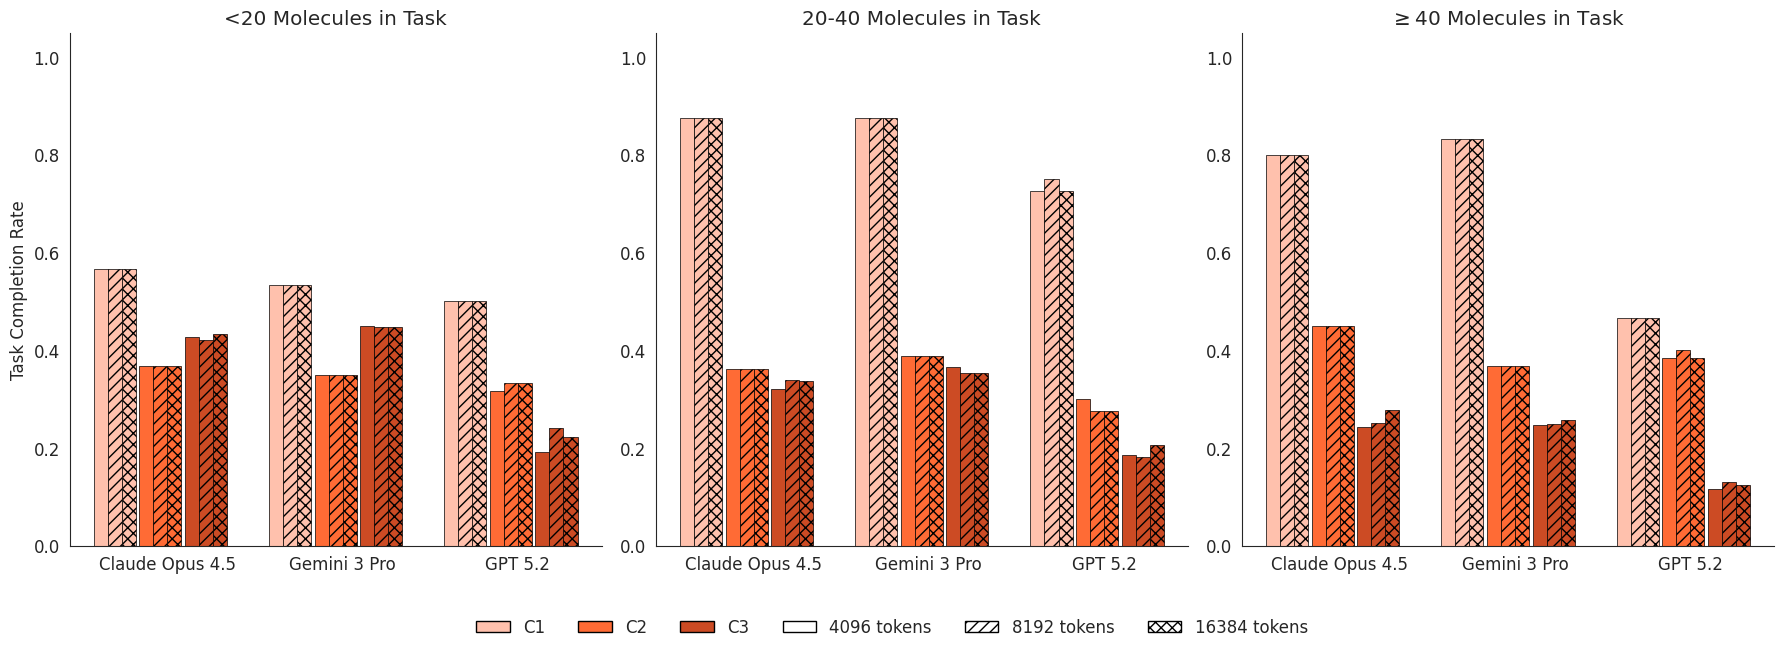


Plot saved to: plots/max_tokens_comparison.png


In [7]:
# Create the final comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define hatching patterns for different max_tokens
hatches = {
    4096: '',       # No pattern
    8192: '///',    # Diagonal stripes
    16384: 'xxx'    # Cross-hatched
}

for i, n_mol_bin in enumerate(['<20', '20-40', '>=40']):
    ax = axes[i]
    
    # Filter data for this bin
    bin_data = all_task_results[all_task_results['n_mol_bin'] == n_mol_bin].copy()
    
    if len(bin_data) == 0:
        print(f"Warning: No data for bin {n_mol_bin}")
        continue
    
    # Create grouped bar plot
    models = sorted(bin_data['Model'].unique())
    tasks = ['C1', 'C2', 'C3']
    max_tokens_list = [4096, 8192, 16384]
    
    x = np.arange(len(models))  # Model positions
    width = 0.08  # Width of each bar (3 bars per task instead of 2)
    gap_between_tasks = 0.02  # Small gap between task groups
    
    # Plot bars for each task and max_tokens setting
    for task_idx, task in enumerate(tasks):
        for tokens_idx, max_tokens in enumerate(max_tokens_list):
            # Get data for this combination
            subset = bin_data[(bin_data['Task'] == task) & (bin_data['max_tokens'] == max_tokens)]
            
            if len(subset) == 0:
                continue
            
            # Sort by model to ensure consistent ordering
            subset = subset.sort_values('Model')
            
            # Calculate position: each task group has 3 adjacent bars (4096, 8192, 16384)
            # with gaps between different tasks
            task_group_start = task_idx * (3 * width + gap_between_tasks)
            total_width = len(tasks) * 3 * width + (len(tasks) - 1) * gap_between_tasks
            offset = task_group_start + tokens_idx * width - total_width / 2
            
            # Plot bars
            bars = ax.bar(
                x + offset,
                subset['Task Completion'],
                width,
                label=f"{task} - {max_tokens}" if i == 0 else None,
                color=custom_colors[task_idx],
                hatch=hatches[max_tokens],
                edgecolor='black',
                linewidth=0.5
            )
    
    # Formatting
    ax.set_ylabel('Task Completion Rate' if i == 0 else '')
    ax.set_xlabel('')
    ax.set_xticks(x)
    ax.set_xticklabels([
        "Claude Opus 4.5",
        "Gemini 3 Pro",
        "GPT 5.2"
    ])
    ax.set_ylim([0, 1.05])
    
    # Title
    title = f'{n_mol_bin} Molecules in Task'
    if n_mol_bin == '>=40':
        title = '$\\geq 40$ Molecules in Task'
    ax.set_title(title)
    
    sns.despine(ax=ax)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = []
# Task colors
for task_idx, task in enumerate(['C1', 'C2', 'C3']):
    legend_elements.append(Patch(facecolor=custom_colors[task_idx], edgecolor='black', label=task))
# Max tokens patterns
for max_tokens in [4096, 8192, 16384]:
    legend_elements.append(Patch(facecolor='white', edgecolor='black', hatch=hatches[max_tokens], label=f'{max_tokens} tokens'))

fig.legend(handles=legend_elements, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.1), frameon=False)

plt.tight_layout()
plt.savefig('plots/max_tokens_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: plots/max_tokens_comparison.png")

## Summary Statistics

In [8]:
# Create summary table showing impact of max_tokens
print("\n" + "="*100)
print("MAX TOKENS IMPACT SUMMARY: Task Completion Rates by Max Tokens Setting")
print("="*100)

summary_rows = []

for task in ['C1', 'C2', 'C3']:
    for model in sorted(all_task_results['Model'].unique()):
        for n_mol_bin in ['<20', '20-40', '>=40']:
            row_data = {'Task': task, 'Model': model, 'N_Mol_Bin': n_mol_bin}
            
            for max_tokens in [4096, 8192, 16384]:
                subset = all_task_results[
                    (all_task_results['Task'] == task) & 
                    (all_task_results['Model'] == model) & 
                    (all_task_results['n_mol_bin'] == n_mol_bin) & 
                    (all_task_results['max_tokens'] == max_tokens)
                ]
                
                if len(subset) > 0:
                    row_data[f'{max_tokens}'] = f"{subset['Task Completion'].values[0]:.3f}"
                else:
                    row_data[f'{max_tokens}'] = 'N/A'
            
            # Only add row if we have at least one value
            if any(row_data.get(str(t)) != 'N/A' for t in [4096, 8192, 16384]):
                summary_rows.append(row_data)

if summary_rows:
    summary_table = pd.DataFrame(summary_rows)
    print(summary_table.to_string(index=False))
    
    # Export to CSV
    Path('analysis_results').mkdir(exist_ok=True)
    summary_table.to_csv('analysis_results/max_tokens_summary.csv', index=False)
    print("\nSummary table exported to: analysis_results/max_tokens_summary.csv")
else:
    print("No data available for summary")


MAX TOKENS IMPACT SUMMARY: Task Completion Rates by Max Tokens Setting
Task                Model N_Mol_Bin  4096  8192 16384
  C1      claude-opus-4-5       <20 0.567 0.567 0.567
  C1      claude-opus-4-5     20-40 0.875 0.875 0.875
  C1      claude-opus-4-5      >=40 0.800 0.800 0.800
  C1 gemini-3-pro-preview       <20 0.533 0.533 0.533
  C1 gemini-3-pro-preview     20-40 0.875 0.875 0.875
  C1 gemini-3-pro-preview      >=40 0.833 0.833 0.833
  C1              gpt-5.2       <20 0.500 0.500 0.500
  C1              gpt-5.2     20-40 0.725 0.750 0.725
  C1              gpt-5.2      >=40 0.467 0.467 0.467
  C2      claude-opus-4-5       <20 0.367 0.367 0.367
  C2      claude-opus-4-5     20-40 0.363 0.363 0.363
  C2      claude-opus-4-5      >=40 0.450 0.450 0.450
  C2 gemini-3-pro-preview       <20 0.350 0.350 0.350
  C2 gemini-3-pro-preview     20-40 0.388 0.388 0.388
  C2 gemini-3-pro-preview      >=40 0.367 0.367 0.367
  C2              gpt-5.2       <20 0.317 0.333 0.333
  C2      

In [33]:
data_pivot = all_task_results.pivot_table(index=['Task', 'Model', 'n_mol_bin'], columns='max_tokens', values='Task Completion')
print("Average improvement for molecules from 4096 to 16384 tokens:", (data_pivot[data_pivot.columns[2]] - data_pivot[data_pivot.columns[0]]).mean())

Average improvement for molecules from 4096 to 16384 tokens: 0.0038900920281092237


/tmp/ipykernel_2681976/2093655230.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_pivot = all_task_results.pivot_table(index=['Task', 'Model', 'n_mol_bin'], columns='max_tokens', values='Task Completion')


In [9]:
# Overall summary (averaged across all bins)
print("\n" + "="*80)
print("OVERALL MAX TOKENS IMPACT (averaged across all molecule count bins)")
print("="*80)

for task in ['C1', 'C2', 'C3']:
    print(f"\n{task}:")
    for model in sorted(all_task_results['Model'].unique()):
        print(f"  {model}:")
        for max_tokens in [4096, 8192, 16384]:
            mean_val = all_task_results[
                (all_task_results['Task'] == task) & 
                (all_task_results['Model'] == model) & 
                (all_task_results['max_tokens'] == max_tokens)
            ]['Task Completion'].mean()
            
            if not np.isnan(mean_val):
                print(f"    {max_tokens} tokens: {mean_val:.3f}")


OVERALL MAX TOKENS IMPACT (averaged across all molecule count bins)

C1:
  claude-opus-4-5:
    4096 tokens: 0.747
    8192 tokens: 0.747
    16384 tokens: 0.747
  gemini-3-pro-preview:
    4096 tokens: 0.747
    8192 tokens: 0.747
    16384 tokens: 0.747
  gpt-5.2:
    4096 tokens: 0.564
    8192 tokens: 0.572
    16384 tokens: 0.564

C2:
  claude-opus-4-5:
    4096 tokens: 0.393
    8192 tokens: 0.393
    16384 tokens: 0.393
  gemini-3-pro-preview:
    4096 tokens: 0.368
    8192 tokens: 0.368
    16384 tokens: 0.368
  gpt-5.2:
    4096 tokens: 0.333
    8192 tokens: 0.336
    16384 tokens: 0.331

C3:
  claude-opus-4-5:
    4096 tokens: 0.330
    8192 tokens: 0.337
    16384 tokens: 0.350
  gemini-3-pro-preview:
    4096 tokens: 0.354
    8192 tokens: 0.350
    16384 tokens: 0.353
  gpt-5.2:
    4096 tokens: 0.164
    8192 tokens: 0.184
    16384 tokens: 0.184
